### Phys 629: Statistical Tools for Physics Research
***Anuradha Gupta***

# Homework 5
### Due: Friday, Oct 6 at 11:59 pm CT

## Problem 1

This week we have only one problem worth 20 points. This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `lecture_11`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `lecture_10`, compute the Fisher uncertainty estimate on the mean.

4) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

5) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

In [2]:
# 1 import data
data = np.load('hw5_data.npy')
meas = data[:,0]
sigma = data[:,1] 
# Compute the sample mean and standard error

def mean(x, sigma):
    mu_hat = (sum(x/sigma**2))/(sum(1/sigma**2))
    return mu_hat

muhat = mean(meas, sigma)
print(muhat, "is the sample mean.")

standard_error = np.std(meas, ddof=1) / np.sqrt(len(meas))
print(standard_error, "is the standard error on the sample mean.")

3.917992034606058 is the sample mean.
0.11565177228177984 is the standard error on the sample mean.


43.16254534646687
3.9179920233353527 is the best-fit mean.


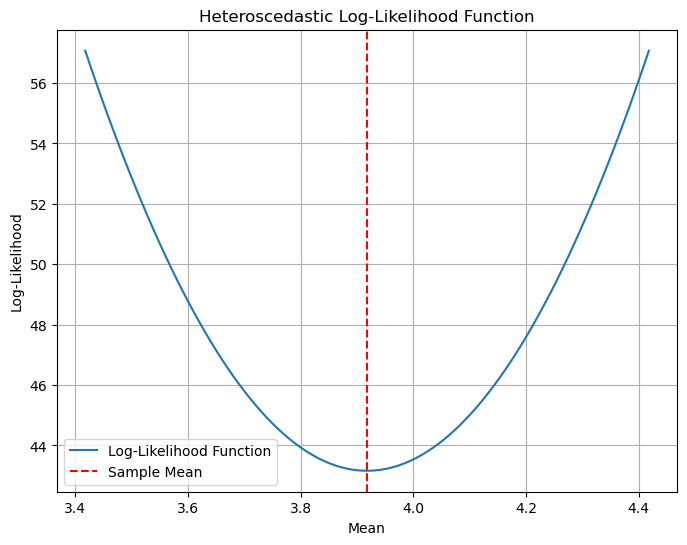

In [3]:
#2 Write a ln-likelihood function for heteroscedastic data
def lnLikelihood(x, mu, sigma):
    lnL = -sum(((x-mu)**2)/(2*sigma**2))
    return -lnL
lnL = lnLikelihood(meas, muhat, sigma)
print(lnL)
# Use it in a fitting algorithm to find the best-fit mean

mu_proposed = np.mean(meas)
result = scipy.optimize.minimize(lnLikelihood, mu_proposed, args=(meas, sigma))

mu_max = result.x[0]
print(mu_max, "is the best-fit mean.")

# Define a range of mean values to evaluate the likelihood
mean_range = np.linspace(muhat - 0.5, muhat + 0.5, 100) 

# Calculate the log-likelihood for each mean value
log_likelihood_values = np.zeros_like(mean_range)
for i, mean in enumerate(mean_range):
    log_likelihood_values[i] = lnLikelihood(mean, meas, sigma)

# Plot the likelihood function
plt.figure(figsize=(8, 6))
plt.plot(mean_range, log_likelihood_values, label="Log-Likelihood Function")
plt.xlabel("Mean")
plt.ylabel("Log-Likelihood")
plt.title("Heteroscedastic Log-Likelihood Function")
plt.axvline(muhat, color='red', linestyle='--', label="Sample Mean")
plt.legend()
plt.grid(True)

plt.show()

In [4]:
#3 Compute the fisher uncertainty estimate on the mean
fisher_information = np.sum(1 / (sigma**2))

print("Fisher matrix error on estimated mean is", fisher_information)

Fisher matrix error on estimated mean is 111.24589698480763


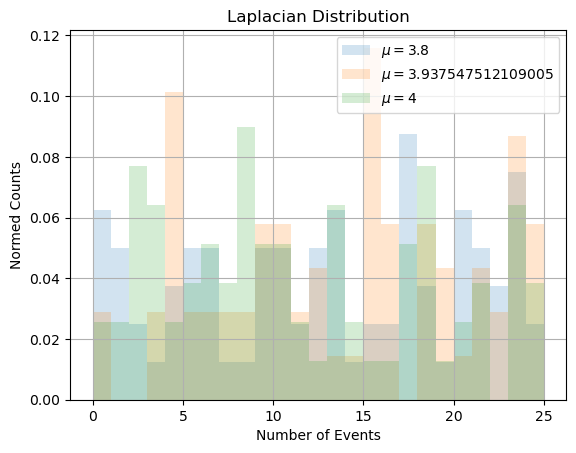

In [19]:
#4 Define a ln-likelihood for a Laplace distribution evaluated on this data
from scipy.stats import laplace
import seaborn as sns

def ln_likelihood_laplace(parameters, meas, sigma):
    mu, delta = parameters
    if delta <= 0:
        return np.inf
    term1 = -np.sum(np.abs(meas - mu) / delta)
    term2 = -len(meas) * np.log(2 * delta)
    return term1 + term2

#Initial guess for mu/delta
muhat = np.mean(meas)
proposed_laplace = [muhat, np.std(meas)]

result_laplace = scipy.optimize.minimize(ln_likelihood_laplace, proposed_laplace, args=(meas, sigma), method='L-BFGS-B')
best_fit_mu_laplace, best_fit_delta_laplace = result_laplace.x

# Generate samples for different values of mu
x = np.linspace(0, 20, 1000)
kpts=np.arange(0,25)
for mu, c in zip([3.8,muhat,4], sns.color_palette()[:3]):
    pdf = laplace.pdf(x, loc=mu, scale=best_fit_delta_laplace)
    # random draws
    randomVariates = laplace.rvs(loc=mu, scale=best_fit_delta_laplace, size=1000)
    # histogram of random draws
    plt.hist(randomVariates, density=True, color=c, alpha=0.2, 
             bins=range(0,26), label='$\mu=' + str(mu) + '$')
    # probability density at bin locations
    #plt.plot(x, pdf, '.', color=c)

#Plot the best-fit parameters
#plt.axvline(best_fit_mu_laplace, color='red', linestyle='--', label="Best-fit $\mu$")
#plt.axvline(best_fit_mu_laplace - best_fit_delta_laplace, color='blue', linestyle='--', label="Best-fit $\mu - \Delta$")
#plt.axvline(best_fit_mu_laplace + best_fit_delta_laplace, color='blue', linestyle='--', label="Best-fit $\mu + \Delta$")

plt.legend()
plt.title("Laplacian Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Normed Counts")
plt.grid(True)

plt.show()

In [16]:
print(result_laplace.x)
print(ln_likelihood_laplace)

[-3051.35852538   168.03031711]
<function ln_likelihood_laplace at 0x7f528d874b80>


In [10]:
#5 Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which is favorted by the data?
n_data_points = len(data)
AIC_gaussian = 2 - 2 * lnLikelihood(result.x, data[:, 0], data[:, 1]) + 2 * 2  # Two parameters (mean, sigma)
AIC_laplace = 2 - 2 * ln_likelihood_laplace(result_laplace.x, data[:, 0], data[:, 1]) + 2 * 2  # Two parameters (𝜇, Δ)

print("AIC for Gaussian Model:", AIC_gaussian)
print("AIC for Laplace Model:", AIC_laplace)


AIC for Gaussian Model: -80.3250906929338
AIC for Laplace Model: 4806.059292767086


In [ ]:
# AIC for the Gaussian Model is lower, so the Gaussian model is favored.